In [175]:
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import os

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
mnist_ds = keras.datasets.mnist
(x_train_full, y_train_full), (x_test, y_test) = mnist_ds.load_data()

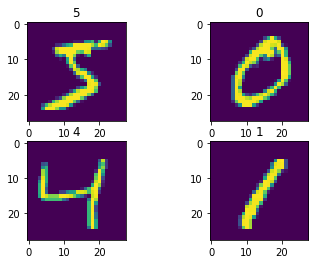

In [65]:
fig, axes = plt.subplots(2,2)
for ax, img, title in zip(axes.ravel(),x_train_full[:4],y_train_full[:4]):
    ax.imshow(img)
    ax.set_title(title)

In [73]:
x_train = x_train_full[:55000]
y_train = y_train_full[:55000]

x_valid = x_train_full[55000:]
y_valid = y_train_full[55000:]

In [84]:
K = keras.backend
def find_lr(model, x, y, min_lr=1e-5, max_lr=1e-1, 
            epochs=1, batch_size=32):
    class ExpLr(keras.callbacks.Callback):
        def __init__(self, factor, **kwargs):
            super().__init__(**kwargs)
            self.factor = factor
            self.rates = []
            self.losses = []
        
        def on_train_batch_end(self, batch, logs=None):
            lr = K.get_value(self.model.optimizer.lr)
            self.losses.append(logs['loss'])
            self.rates.append(lr)
            new_lr = lr * self.factor
            K.set_value(self.model.optimizer.lr, new_lr)
            
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.lr)
    
    iters = len(x) // batch_size * epochs
    factor = (max_lr / min_lr) ** (1 / iters)
    explr = ExpLr(factor)
    
    model.fit(x,y,epochs=epochs,batch_size=batch_size,
             callbacks=[explr])
    
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return explr.rates, explr.losses

In [85]:
def make_model(lr=1e-3):
    model = keras.models.Sequential([
        keras.layers.Input([28,28]),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(300),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(300),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [86]:
rates, losses = find_lr(make_model(lr=1e-3), 
                        x_train, y_train, 
                       min_lr=1e-4, max_lr=1e0)

Train on 55000 samples
55000/55000 [==============================] - 31s 573us/sample - loss: 3163.2674 - accuracy: 0.7168


(0.025045648, 3.1079633)

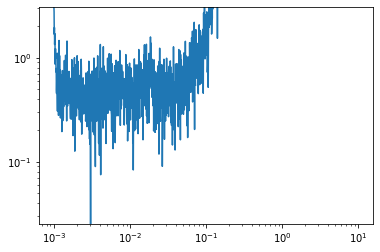

In [92]:
plt.loglog(rates, losses)
plt.ylim([min(losses), (losses[0] + min(losses))])

In [187]:
epochs = 20
batch_size = 32
steps = len(x_train) * epochs // batch_size
# model = make_model(1e-3)
# def fit_1cycle(batch, logs=None):

def schedule_1cycle(model, steps, min_lr=1e-3, max_lr=1e-2):
    t = tf.range(0, steps, dtype=tf.float32)
    rates =  min_lr + max_lr * tf.math.sin(math.pi / (steps * 0.9) * t)
    rates = tf.where(t < steps * 0.9, rates, min_lr * tf.math.exp(-(t-steps * 0.9)/(steps*0.025)))
    
    def schedule(batch, logs=None):
        if len(rates == 1):
            K.set_value(model.optimizer.lr, rates[0])
        else:
            K.set_value(model.optimizer.lr, rates.pop())

In [188]:
model = make_model(lr=1e-3)

os.makedirs('models/11_lecture/', exist_ok=True)
cyclelr_cb = keras.callbacks.LambdaCallback(on_batch_end=schedule_1cycle(model,steps, min_lr=1e-3, max_lr=1e-2))
save_model = keras.callbacks.ModelCheckpoint('models/11_lecture/mnist-stage-1.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

model.fit(x_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[cyclelr_cb, save_model, early_stopping],
          validation_data=(x_valid, y_valid),
         )

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 31s 567us/sample - loss: 0.2895 - accuracy: 0.9120 - val_loss: 0.3897 - val_accuracy: 0.9596
Epoch 2/20
55000/55000 [==============================] - 41s 739us/sample - loss: 0.1621 - accuracy: 0.9486 - val_loss: 0.4867 - val_accuracy: 0.9654
Epoch 3/20
55000/55000 [==============================] - 36s 651us/sample - loss: 0.1343 - accuracy: 0.9581 - val_loss: 1.2292 - val_accuracy: 0.9730
Epoch 4/20
55000/55000 [==============================] - 47s 850us/sample - loss: 0.1173 - accuracy: 0.9639 - val_loss: 0.9023 - val_accuracy: 0.9734
Epoch 5/20
55000/55000 [==============================] - 40s 723us/sample - loss: 0.0953 - accuracy: 0.9701 - val_loss: 0.4465 - val_accuracy: 0.9728
Epoch 6/20
55000/55000 [==============================] - 41s 745us/sample - loss: 0.0917 - accuracy: 0.9702 - val_loss: 1.6461 - val_accuracy: 0.9740
Epoch 7/20
55000/55000 [=====================

In [189]:
model = keras.models.load_model('models/11_lecture/mnist-stage-1.h5')
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 157us/sample - loss: 0.6176 - accuracy: 0.9742


[0.6176494937248994, 0.9742]